## Step-1 Importing Tiny Story Dataset

In [1]:
import os, shutil

input_dir = "/kaggle/input/slm-preprocessed-bin"
working_dir = "/kaggle/working"

for fname in ["train.bin", "validation.bin"]:
    src = os.path.join(input_dir, fname)
    dst = os.path.join(working_dir, fname)
    if not os.path.exists(dst):  # avoid duplicate copy
        shutil.copy(src, dst)
        print(f"Copied {fname} → {working_dir}")
    else:
        print(f"{fname} already exists in {working_dir}")

Copied train.bin → /kaggle/working
Copied validation.bin → /kaggle/working


In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 41.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.


In [4]:
pip install -U datasets

Note: you may need to restart the kernel to use updated packages.


In [5]:
from datasets import load_dataset

In [6]:
ds = load_dataset("roneneldan/TinyStories") #https://huggingface.co/datasets/roneneldan/TinyStories/viewer/default/train

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

## Step-2: Tokenization of Dataset

In [8]:
pip install tiktoken

Note: you may need to restart the kernel to use updated packages.


In [9]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

In [10]:
enc = tiktoken.get_encoding("gpt2")

In [11]:
block_size = 128

In [12]:
def process(example):
    ids = enc.encode_ordinary(example['text'])  # Tokenize the text
    # Ensure sequence length does not exceed block_size
    ids = ids[:block_size]  # Trim if longer than block_size
    out = {'ids': ids, 'len': len(ids)}  # Save 'ids' and 'len' for later access
    return out

In [13]:
import os

data_dir = "/kaggle/working"

train_bin_path = os.path.join(data_dir, "train.bin")
val_bin_path = os.path.join(data_dir, "validation.bin")

# Checking if both preprocessed .bin files already exist, if yes then no need to do tokenization again
if os.path.exists(train_bin_path) and os.path.exists(val_bin_path):
    print("✅ train.bin and val.bin already exist in /kaggle/working — skipping tokenization.")
else:
    print("⚙️ train.bin or val.bin not found — running tokenization...")

    # run your tokenization pipeline
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="Tokenizing the splits",
        num_proc=os.cpu_count(),
    )

    print(tokenized['train'][0])

    # save tokenized dataset to .bin
    for split in tokenized.keys():
        dset = tokenized[split]
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = os.path.join(data_dir, f"{split}.bin")
        arr = np.memmap(filename, dtype=np.uint16, mode='w+', shape=(arr_len,))
        idx = 0
        for i in tqdm(range(len(dset)), desc=f'Writing {split}.bin'):
            arr[idx: idx + dset[i]['len']] = dset[i]['ids']
            idx += dset[i]['len']
        arr.flush()

    print("✅ Tokenization completed and saved train.bin / val.bin to /kaggle/working.")

✅ train.bin and val.bin already exist in /kaggle/working — skipping tokenization.


## Step 3: Create Input-Output batches for the dataset

In [15]:
import torch

In [16]:
def get_batch(split):
    # Recreate np.memmap every batch to avoid memory leaks
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')

    # Ensure indices are chosen such that sequences are within the block_size
    ix = torch.randint(len(data) - block_size, (batch_size,))  # Make sure we have enough tokens for the block

    # Slice each sequence to ensure it's exactly block_size long
    x = torch.stack([torch.from_numpy(data[i:i+block_size].astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy(data[i+1:i+1+block_size].astype(np.int64)) for i in ix])

    # Move data to GPU if using CUDA
    if device_type == 'cuda':
        # Pin arrays for asynchronous transfer to GPU
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)

    return x, y

## Step 4: Define the SLM Model Architecture



In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)
    
        tok_emb = self.transformer.wte(idx)             # (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos)             # (t, n_embd) -> broadcasts to (b,t,n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)                        # (b, t, vocab_size)
        return logits


    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            # crop context if it exceeds block size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            
            # forward pass → logits
            logits = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            
            # top-k filtering (nucleus sampling)
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            
            # sample from distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            
            # append sampled token
            idx = torch.cat((idx, idx_next), dim=1)
        
        return idx

In [29]:
config = GPTConfig(
    vocab_size=50257,
    block_size=128,
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.15, #0.1
    bias=True
)

model = GPT(config)

block_size = config.block_size

## Step 5: Define the loss function

In [19]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits = model(X)
                    loss = F.cross_entropy(
                        logits.view(-1, logits.size(-1)),
                        Y.view(-1),
                        ignore_index=-1
                    )
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [20]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4
max_iters = 20000
warmup_steps = int(0.02 * max_iters)
min_lr = 1e-5
eval_iters = 500
batch_size = 64 
block_size = 128

gradient_accumulation_steps = 16

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu'

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [21]:
#move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# activating multi-gpu if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)

Using 2 GPUs!


## Step 7: Define SLM Training Configuration Part 2

In [22]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.05, eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps])

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipykernel_48/3962898220.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [23]:
print(torch.cuda.device_count(), "GPUs available")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

2 GPUs available
GPU 0: Tesla T4
GPU 1: Tesla T4


## Step 8: Pre-train the SLM

In [24]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

patience = 5
patience_counter = 0

model = model.to(device)

# Training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Evaluate
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list.append(losses['train'])
        validation_loss_list.append(losses['val'])

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            patience_counter = 0  # reset patience
            # Save best model
            if isinstance(model, torch.nn.DataParallel):
                torch.save(model.module.state_dict(), best_model_params_path)
            else:
                torch.save(model.state_dict(), best_model_params_path)
        else:
            patience_counter += 1
            print(f"⚠️ No improvement for {patience_counter}/{patience} evals")
            if patience_counter >= patience:
                print(f"⏹️ Early stopping triggered at epoch {epoch}")
                break

    # Training batch
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits = model(X)
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            y.view(-1),
            ignore_index=-1
        )
        loss = loss.mean() / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scheduler.step()
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 500: train loss 9.2360, val loss 9.2339
Current learning rate: 0.00004
Epoch 1000: train loss 8.5250, val loss 8.5194
Current learning rate: 0.00004
Epoch 1500: train loss 8.0105, val loss 8.0052
Current learning rate: 0.00005
Epoch 2000: train loss 7.5101, val loss 7.5022
Current learning rate: 0.00005
Epoch 2500: train loss 7.0357, val loss 7.0315
Current learning rate: 0.00006
Epoch 3000: train loss 6.5715, val loss 6.5679
Current learning rate: 0.00006
Epoch 3500: train loss 6.1544, val loss 6.1479
Current learning rate: 0.00007
Epoch 4000: train loss 5.7649, val loss 5.7598
Current learning rate: 0.00008
Epoch 4500: train loss 5.4790, val loss 5.4739
Current learning rate: 0.00008
Epoch 5000: train loss 5.2900, val loss 5.2812
Current learning rate: 0.00009
Epoch 5500: train loss 5.1619, val loss 5.1557
Current learning rate: 0.00009
Epoch 6000: train loss 5.0621, val loss 5.0499
Current learning rate: 0.00010


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 6500: train loss 4.9671, val loss 4.9638
Current learning rate: 0.00010
Epoch 7000: train loss 4.9509, val loss 4.9440
Current learning rate: 0.00010
Epoch 7500: train loss 4.9089, val loss 4.9033
Current learning rate: 0.00010
Epoch 8000: train loss 4.8981, val loss 4.8876
Current learning rate: 0.00010
Epoch 8500: train loss 4.8815, val loss 4.8742
Current learning rate: 0.00010
Epoch 9000: train loss 4.8751, val loss 4.8701
Current learning rate: 0.00010
Epoch 9500: train loss 4.8486, val loss 4.8487
Current learning rate: 0.00010
Epoch 10000: train loss 4.8605, val loss 4.8487
Current learning rate: 0.00010
Epoch 10500: train loss 4.8535, val loss 4.8393
Current learning rate: 0.00010
Epoch 11000: train loss 4.8664, val loss 4.8541
Current learning rate: 0.00010
⚠️ No improvement for 1/5 evals
Epoch 11500: train loss 4.9037, val loss 4.8924
Current learning rate: 0.00010
⚠️ No improvement for 2/5 evals
Epoch 12000: train loss 4.8636, val loss 4.8579
Current learning rate: 0.0

In [30]:
import torch

#Load model
model = GPT(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"

# handle DataParallel checkpoints automatically
state_dict = torch.load(best_model_params_path, map_location=device)
if any(k.startswith("module.") for k in state_dict.keys()):
    state_dict = {k[len("module."):]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("✅ Model loaded successfully on", device)

# INPUT
sentence = "Once upon a time there was a pumpkin."
context = torch.tensor(enc.encode_ordinary(sentence), dtype=torch.long, device=device).unsqueeze(0)

#Text generation or Inference
with torch.no_grad():
    y = model.generate(context, max_new_tokens=200, temperature=0.8, top_k=50)

generated_text = enc.decode(y[0].tolist())
print("📝 Generated text:\n")
print(generated_text)

✅ Model loaded successfully on cuda
📝 Generated text:

Once upon a time there was a pumpkin. He. She told her. She saw a little girl. One day. One day,. On the park. They didn't the. She asked do feel in the, "Let she was that always on. She's. She knew. She in the. They. She was blue really in the dad looked, things and smiled and all and. 


"Look,.
Lily was. As and. He said, "This.
He said and said, "Look, know, I for he went to his with then and. He picked and not. One day, the friend was very tall. She was special know know know we wasummy and looked just feel said, "No, just, really and not and. 


John was, we the friend and quickly said, "I.

But her, and and doing around the special are a shiny. She was doing and the bear said, "I am their friends. 


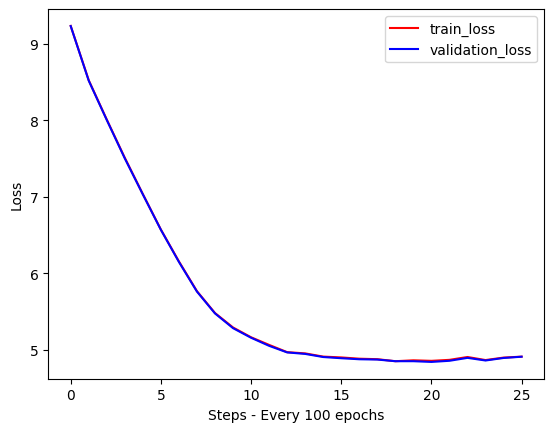

In [33]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'r', label='train_loss')
plt.plot(validation_loss_list_converted, 'b', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [34]:
import torch
import os

save_dir = "/kaggle/working/small_gpt_model"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "small_gpt_weights.pt")
torch.save(model.state_dict(), model_path)

import json
config_dict = {
    "block_size": config.block_size,
    "vocab_size": config.vocab_size,
    "n_layer": config.n_layer,
    "n_head": config.n_head,
    "n_embd": config.n_embd,
    "dropout": config.dropout,
    "bias": config.bias
}
with open(os.path.join(save_dir, "config.json"), "w") as f:
    json.dump(config_dict, f, indent=2)

print(f"✅ Model and config saved in: {save_dir}")

✅ Model and config saved in: /kaggle/working/small_gpt_model


In [35]:
import pickle
with open(os.path.join(save_dir, "tokenizer.pkl"), "wb") as f:
    pickle.dump(enc, f)